In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import pink_utils as pu
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.ensemble.forest import RandomForestRegressor
from sklearn import model_selection

In [2]:
hm = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images_EDMatrix.bin')
images = pu.image_binary('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images.bin')
df = pd.read_csv('../Experiment/Experiment_F3W2_95_5/Test_Images/RGZ_Test_Images_Dataframe.csv')

In [3]:
df.shape

(7464, 78)

In [4]:
images.file_head

(7464, 2, 167, 167)

In [5]:
hm.file_head

(7464, 15, 15, 1)

In [6]:
def ed_to_pb(ed):
    ed = ed - np.min(ed)
    ed = 1. / (1.+ed)
    ed = ed / np.sum(ed)
    
    return ed

print('Loading the heatmaps')
maps = [ed_to_pb(hm.ed(index=i, prob=False)) for i in range(hm.file_head[0])]

Loading the heatmaps


In [7]:
book = defaultdict(list)

for c, row in df.iterrows():
    label = row['label'].replace('_','\_')
    book[row['label']].append(maps[c])

In [8]:
som = pu.som('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5/F3W2S_95_5_6_19.bin')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


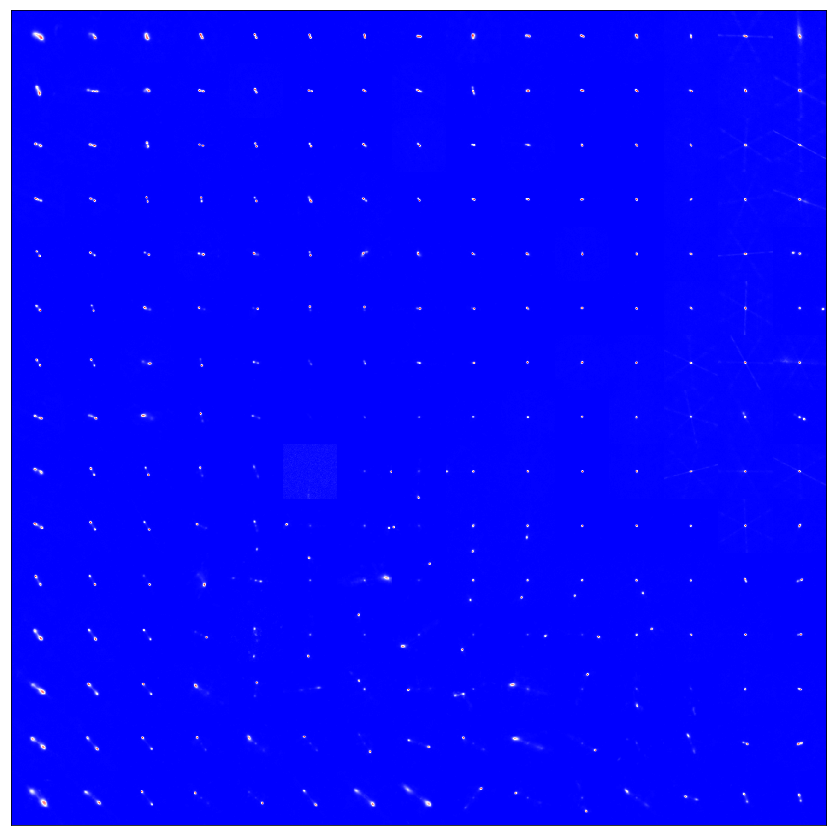

In [9]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=0), cmap='bwr')
pu.no_ticks(ax)

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


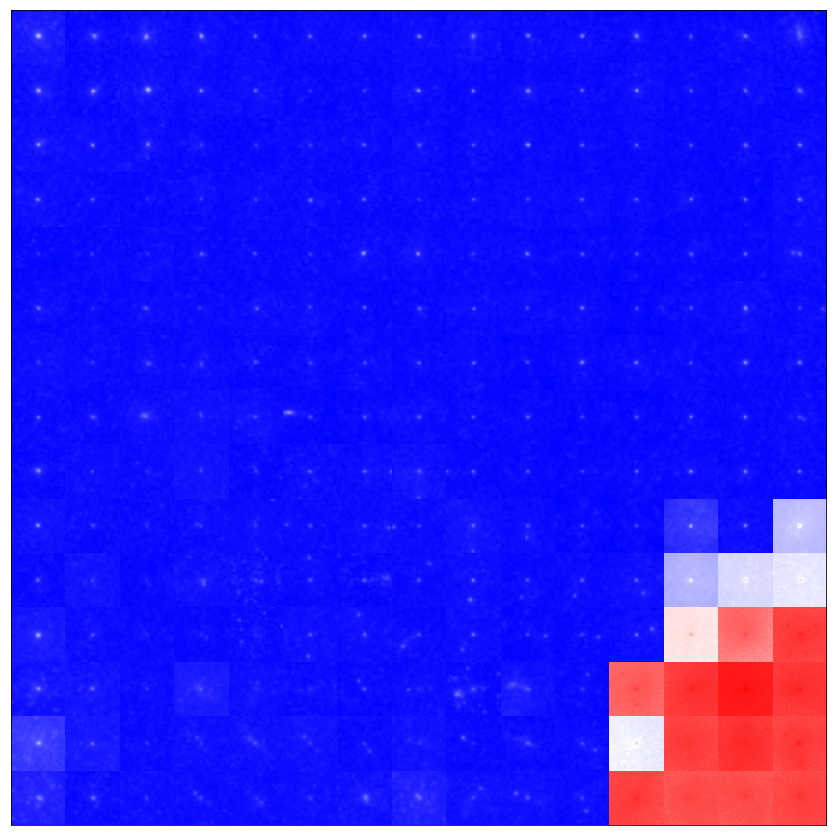

In [10]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=1), cmap='bwr')
pu.no_ticks(ax)

fig.show()

In [11]:
np.random.seed(7464)
index = np.random.permutation(len(maps))

labels = df['label']
num_comp  = np.array([int(i.split('_')[0]) for i in labels])[index]
num_peaks = np.array([int(i.split('_')[1]) for i in labels])[index]

heatmaps  = np.array(maps).reshape(-1,15*15)[index]
total = heatmaps.shape[0]

suf_df = df.iloc[index]
a = []

for count, (i, row) in enumerate(suf_df.iterrows()):
    a.append(np.append(heatmaps[count], row['consensus.radio_level']))

heatmaps = np.array(a)
heatmaps.shape

(7464, 226)

In [12]:
n_estimators = 64*2 # how many trees, should be 256
cores = 8 # number of cpu cores to speed it up

peaks_rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)
comp_rf  = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)

peaks_skf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)
comp_skf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)

peaks_res = model_selection.cross_val_predict(peaks_rf, heatmaps, num_peaks, cv=peaks_skf, n_jobs=-1)
comp_res = model_selection.cross_val_predict(comp_rf, heatmaps, num_comp, cv=comp_skf, n_jobs=-1)

In [13]:
print(index)
suf_df = df.loc[index]
print(suf_df)
print(df)

[1419 6854 1864 ... 7412 5285 3306]
      Unnamed: 0  Unnamed: 0.1  catalog_id             rgz_name zooniverse_id  \
1419       83395         83395       93316  RGZJ133205.7+121406    ARG0002vhs   
6854       64186         64186       72064  RGZJ102141.8+161855    ARG0002l1t   
1864        7493          7493        8837  RGZJ120207.9+105851    ARG0002zqj   
6825       14259         14259       16838  RGZJ123711.4+493712    ARG0000m36   
4741       11803         11803       14122  RGZJ162804.9+133230    ARG0002rv4   
1654       49347         49347       55618  RGZJ154933.0+013642    ARG0003qp7   
2734       99178         99178      110783  RGZJ090230.1+350509    ARG0001fim   
6819       57284         57284       64428  RGZJ143353.4+184521    ARG0002fja   
5360       24602         24602       28246  RGZJ084520.5+482939    ARG0000oes   
1701       75873         75873       85017  RGZJ012957.9+052353    ARG0003g9a   
4434       30273         30273       34533  RGZJ174239.6+544738    ARG000

In [14]:
suf_df['peak_res'] = pd.Series(peaks_res, index=index)
suf_df['comp_res'] = pd.Series(comp_res, index=index)
suf_df['no_comp']  = pd.Series(num_comp, index=index)
suf_df['no_peak']  = pd.Series(num_peaks, index=index)

suf_df['diff_peak']    = suf_df['no_peak'] - suf_df['peak_res']
suf_df['diff_comp']    = suf_df['no_comp']  - suf_df['comp_res'] 
suf_df['peak_correct'] = (suf_df['diff_peak'] > -0.5) & (suf_df['diff_peak'] < 0.5)
suf_df['comp_correct'] = (suf_df['diff_comp'] > -0.5) & (suf_df['diff_comp'] < 0.5)

suf_df['cl_group'] = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
suf_df['Radio_CL'] = suf_df['cl_group']

suf_df[['peak_res', 'no_peak', 'diff_peak','peak_correct']]

,peak_res,no_peak,diff_peak,peak_correct
1419,1.000000,1,0.000000,True
6854,2.304688,3,0.695312,False
1864,1.000000,1,0.000000,True
6825,2.898438,3,0.101562,True
4741,2.015625,2,-0.015625,True
1654,1.078125,1,-0.078125,True
2734,1.632812,2,0.367188,True
6819,2.484375,3,0.515625,False
5360,2.273438,2,-0.273438,True
1701,1.187500,1,-0.187500,True


In [15]:
print(suf_df.pivot_table(index=['Radio_CL','comp_correct'], 
                   columns='label', 
                   values='diff_comp',
                   margins=True,
                   margins_name='Summary',
                   aggfunc={'diff_comp':lambda x: f"{len(x):.0f} / {np.sum(np.abs(x))/len(x):.2f}" }).to_latex(float_format='%.0f',
                                                                              bold_rows=True))

\begin{tabular}{lllllllll}
\toprule
        & \textbf{label} &          1\_1 &          1\_2 &         1\_3 &          2\_2 &         2\_3 &         3\_3 &      Summary \\
\textbf{Radio\_CL} & \textbf{comp\_correct} &              &              &             &              &             &             &              \\
\midrule
\textbf{0.6-0.7} & \textbf{False} &    31 / 0.91 &    48 / 0.86 &   46 / 0.97 &    20 / 0.64 &   20 / 0.62 &  198 / 0.80 &   363 / 0.82 \\
        & \textbf{True} &   103 / 0.15 &    53 / 0.21 &    4 / 0.38 &   380 / 0.17 &  158 / 0.23 &   81 / 0.34 &   779 / 0.20 \\
\textbf{0.7-0.8} & \textbf{False} &    14 / 1.05 &    36 / 0.86 &   35 / 1.00 &    22 / 0.64 &   24 / 0.62 &  199 / 0.78 &   330 / 0.80 \\
        & \textbf{True} &    52 / 0.12 &    25 / 0.19 &    7 / 0.27 &   472 / 0.15 &  197 / 0.20 &   93 / 0.33 &   846 / 0.18 \\
\textbf{0.8-0.9} & \textbf{False} &     9 / 0.84 &    42 / 0.77 &   36 / 0.98 &    11 / 0.57 &   20 / 0.67 &  106 / 0.83 &   224 / 0.8

In [16]:
print(suf_df.pivot_table(index=['Radio_CL','peak_correct'], 
                   columns='label', 
                   values='diff_peak',
                   margins=True,
                   margins_name='Summary',
                   aggfunc={'diff_peak':lambda x: f"{len(x):.0f} / {np.sum(np.abs(x))/len(x):.2f}" }).to_latex(float_format='%.0f',
                                                                              bold_rows=True))

\begin{tabular}{lllllllll}
\toprule
        & \textbf{label} &          1\_1 &          1\_2 &         1\_3 &          2\_2 &         2\_3 &         3\_3 &      Summary \\
\textbf{Radio\_CL} & \textbf{peak\_correct} &              &              &             &              &             &             &              \\
\midrule
\textbf{0.6-0.7} & \textbf{False} &    43 / 0.96 &    16 / 0.65 &   22 / 0.71 &    93 / 0.64 &   54 / 0.71 &   83 / 0.73 &   311 / 0.73 \\
        & \textbf{True} &    91 / 0.12 &    85 / 0.16 &   28 / 0.27 &   307 / 0.21 &  124 / 0.27 &  196 / 0.26 &   831 / 0.22 \\
\textbf{0.7-0.8} & \textbf{False} &    15 / 1.11 &    11 / 0.75 &   15 / 0.81 &    84 / 0.68 &   51 / 0.72 &   71 / 0.71 &   247 / 0.74 \\
        & \textbf{True} &    51 / 0.10 &    50 / 0.17 &   27 / 0.25 &   410 / 0.18 &  170 / 0.23 &  221 / 0.24 &   929 / 0.20 \\
\textbf{0.8-0.9} & \textbf{False} &    10 / 0.99 &    10 / 0.67 &   13 / 0.75 &    88 / 0.64 &   55 / 0.72 &   37 / 0.76 &   213 / 0.7

In [17]:
suf_df.pivot_table(index=['label','Radio_CL'], 
                   columns='comp_correct', 
                   values='diff_comp',
                   margins=True,
                   margins_name='Summary',
                   aggfunc={'diff_comp':lambda x: f"{len(x):.0f} / {np.sum(np.abs(x))/len(x):.2f}" })

comp_correct            False         True      Summary
label   Radio_CL                                       
1_1     0.6-0.7     31 / 0.91   103 / 0.15   134 / 0.32
        0.7-0.8     14 / 1.05    52 / 0.12    66 / 0.32
        0.8-0.9      9 / 0.84    52 / 0.13    61 / 0.23
        0.9-1.0      2 / 0.58  1684 / 0.00  1686 / 0.00
1_2     0.6-0.7     48 / 0.86    53 / 0.21   101 / 0.52
        0.7-0.8     36 / 0.86    25 / 0.19    61 / 0.58
        0.8-0.9     42 / 0.77    36 / 0.24    78 / 0.52
        0.9-1.0     33 / 0.75  1513 / 0.02  1546 / 0.03
1_3     0.6-0.7     46 / 0.97     4 / 0.38    50 / 0.92
        0.7-0.8     35 / 1.00     7 / 0.27    42 / 0.88
        0.8-0.9     36 / 0.98     6 / 0.36    42 / 0.89
        0.9-1.0     50 / 0.79   591 / 0.02   641 / 0.08
2_2     0.6-0.7     20 / 0.64   380 / 0.17   400 / 0.20
        0.7-0.8     22 / 0.64   472 / 0.15   494 / 0.17
        0.8-0.9     11 / 0.57   501 / 0.12   512 / 0.13
        0.9-1.0     38 / 0.82   141 / 0.16   179 / 0.30
2_3     0.6-0.7     20 / 0.62   158 / 0.23   178 / 0.27
        0.7-0.8     24 / 0.62   197 / 0.20   221 / 0.25
        0.8-0.9     20 / 0.67   155 / 0.17   175 / 0.22
        0.9-1.0     15 / 0.76    42 / 0.16    57 / 0.32
3_3     0.6-0.7    198 / 0.80    81 / 0.34   279 / 0.66
        0.7-0.8    199 / 0.78    93 / 0.33   292 / 0.63
        0.8-0.9    106 / 0.83    41 / 0.32   147 / 0.69
        0.9-1.0     21 / 1.16     1 / 0.29    22 / 1.12
Summary           1076 / 0.81  6388 / 0.08  7464 / 0.18

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


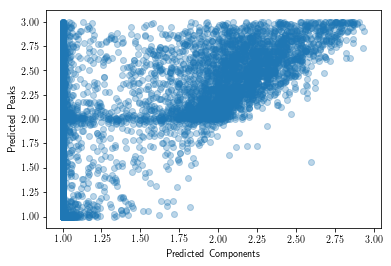

In [18]:
fig, ax = plt.subplots(1,1)

ax.scatter(suf_df['comp_res'], suf_df['peak_res'], alpha=0.3)

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


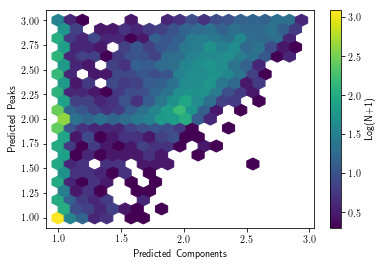

In [19]:
fig, ax = plt.subplots(1,1)

hb = ax.hexbin(suf_df['comp_res'], suf_df['peak_res'], 
               bins='log', gridsize=20, mincnt=1)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Log(N+1)')

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()
# fig.savefig('Images/Predicted_Features_Heatmap.pdf')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


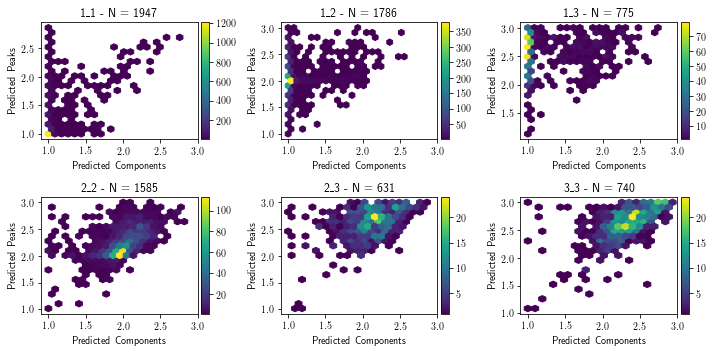

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def subplot_cbar(fig, ax, im):
        divider = make_axes_locatable(ax)
        cax0 = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax0)
    

fig, axes = plt.subplots(2,3, figsize=(10, 5))

for c, (l, g) in enumerate(suf_df.groupby('label')):
    l = l.replace('_', '\_')

    ax = axes.flatten()[c]
    im = ax.hexbin(g['comp_res'], g['peak_res'], gridsize=20, mincnt=1)
    ax.set(title=f'{l} - N = {g.shape[0]}', xlim=[0.9,3],
          xlabel='Predicted Components',
          ylabel='Predicted Peaks')
    
    subplot_cbar(fig, ax, im)

fig.tight_layout()
fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


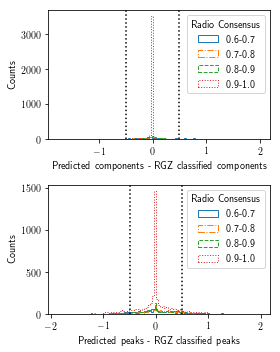

In [21]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(4,5))
linestyles = [':','--','-.','-'][::-1]

for c, (l, g) in enumerate(suf_df.groupby('cl_group')):
    ax1.hist(g['diff_comp'], bins=100, label=f'{l}', histtype='step', linestyle=linestyles[c])
    ax2.hist(g['diff_peak'], bins=100, label=f'{l}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.axvline(-0.5, linestyle=':', color='black')
ax1.axvline(0.5, linestyle=':', color='black')

ax2.axvline(-0.5, linestyle=':', color='black')
ax2.axvline(0.5, linestyle=':', color='black')


ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()
# fig.savefig('Images/Figure_MSE_Histogram_CL_Trained_CL_Feature.pdf')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


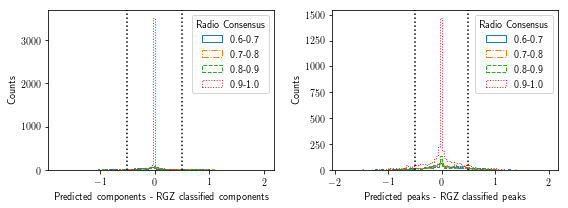

In [22]:
bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
linestyles = [':','--','-.','-'][::-1]

for c, (l, g) in enumerate(suf_df.groupby('cl_group')):
    ax1.hist(g['diff_comp'], bins=100, label=f'{l}', histtype='step', linestyle=linestyles[c])
    ax2.hist(g['diff_peak'], bins=100, label=f'{l}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.axvline(-0.5, linestyle=':', color='black')
ax1.axvline(0.5, linestyle=':', color='black')

ax2.axvline(-0.5, linestyle=':', color='black')
ax2.axvline(0.5, linestyle=':', color='black')


ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()
# fig.savefig('Images/Figure_MSE_Histogram_CL_Trained_CL_Feature_Horizontal.pdf')

In [23]:
val_comp = comp_res - num_comp
val_peaks = peaks_res - num_peaks

mask_comp = (val_comp >= -0.5) & (val_comp < 0.5)
mask_peaks = (val_peaks > -0.5) & (val_peaks < 0.5)

print(np.sum(mask_comp)/len(val_comp))
print(np.sum(np.abs(val_comp[mask_comp])))
print(np.sum(mask_peaks)/len(val_comp))
print(np.sum(np.abs(val_peaks[mask_peaks])))


0.8569131832797428
503.1875
0.8034565916398714
907.0444010416667


In [24]:
for l, g in suf_df.groupby('label'):
    mask = (g['diff_comp'] >= -0.5) & (g['diff_comp'] < 0.5)
    print(l, f'{np.sum(mask)/g.shape[0]:.3f}', f"{np.sum(g['diff_comp'][mask]):.3f}")

mask = (suf_df['diff_comp'] >= -0.5) & (suf_df['diff_comp'] < 0.5)
print('All', f'{np.sum(mask)/suf_df.shape[0]:.3f}', f"{np.sum(suf_df['diff_comp'][mask]):.3f}")

1_1 0.971 -33.148
1_2 0.913 -50.477
1_3 0.786 -18.727
2_2 0.944 -20.188
2_3 0.883 -52.070
3_3 0.292 71.547
All 0.857 -103.062


In [25]:
for l, g in suf_df.groupby('label'):
    mask = (g['diff_peak'] >= -0.5) & (g['diff_peak'] < 0.5)
    print(l, f'{np.sum(mask)/g.shape[0]:.3f}', f"{np.sum(g['diff_peak'][mask]):.3f}")

mask = (suf_df['diff_peak'] >= -0.5) & (suf_df['diff_peak'] < 0.5)
print('All', f'{np.sum(mask)/suf_df.shape[0]:.3f}', f"{np.sum(suf_df['diff_peak'][mask]):.3f}")

1_1 0.859 -99.117
1_2 0.871 -36.197
1_3 0.637 122.828
2_2 0.825 -210.096
2_3 0.708 111.201
3_3 0.734 131.084
All 0.806 19.703
